In [1]:
import os

# os.environ["TORCH_LOGS"] = "+dynamo"
# os.environ["TORCHDYNAMO_VERBOSE"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import time


import torch

torch.set_grad_enabled(False)


from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler


from sfast.compilers.diffusion_pipeline_compiler import compile, CompilationConfig


from diffusers import AutoencoderTiny


def load_model():

    model = StableDiffusionPipeline.from_pretrained(
        # "stabilityai/sd-turbo",
        "segmind/tiny-sd",
        # "nota-ai/bk-sdm-tiny",
        # "segmind/small-sd",
        torch_dtype=torch.float16,
    )

    model.scheduler = EulerAncestralDiscreteScheduler.from_config(
        model.scheduler.config
    )

    model.safety_checker = None

    model.to(torch.device("cuda"))
    return model


model = load_model()


model.vae = AutoencoderTiny.from_pretrained(
    "madebyollin/taesd",
    torch_device="cuda",
    torch_dtype=torch.float16,
)


model.vae = model.vae.cuda()


config = CompilationConfig.Default()


# xformers and Triton are suggested for achieving best performance.


try:

    import xformers

    config.enable_xformers = True


except ImportError:

    print("xformers not installed, skip")


try:
    import triton

    config.enable_triton = True


except ImportError:

    print("Triton not installed, skip")


# CUDA Graph is suggested for small batch sizes and small resolutions to reduce CPU overhead.


# But it can increase the amount of GPU memory used.


# For StableVideoDiffusionPipeline it is not needed.


config.enable_cuda_graph = True


# model = compile(model, config)


kwarg_inputs = dict(
    prompt="(masterpiece:1,2), best quality",
    height=512,
    width=512,
    num_inference_steps=1,
    num_images_per_prompt=1,
)


# NOTE: Warm it up.


# The initial calls will trigger compilation and might be very slow.


# After that, it should be very fast.


for _ in range(3):

    output_image = model(**kwarg_inputs).images[0]


# Let's see it!


# Note: Progress bar might work incorrectly due to the async nature of CUDA.


begin = time.time()


output_image = model(**kwarg_inputs).images[0]


print(f"Inference time: {time.time() - begin:.3f}s")


# Let's view it in terminal!
from sfast.utils.term_image import print_image


# print_image(output_image, max_width=80)

/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `to

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/user-name-goes-here/.local/lib/python3.11/site-packages/diffusers/models/modeling_utils.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpo

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Inference time: 0.033s


In [2]:
begin = time.time()
steps = 90
model.set_progress_bar_config(disable=True)
initial_prompt = str(kwarg_inputs["prompt"])
for i in range(steps):
    kwarg_inputs["prompt"] = initial_prompt + f"{i}"
    output_image = model(**kwarg_inputs).images[0]
total = time.time() - begin
print(f"Inference time: {total}s {total/steps}s per image")

Inference time: 2.68898606300354s 0.029877622922261555s per image


### Custom forward

In [3]:
from diffusers import DDPMScheduler

sched = DDPMScheduler.from_pretrained("stabilityai/sd-turbo", subfolder="scheduler")
sched.set_timesteps(1, device="cuda")
sched.alphas_cumprod = sched.alphas_cumprod.cuda()
sched.betas = sched.betas.to(torch.float16).cuda()
sched.alphas = sched.alphas.to(torch.float16).cuda()
sched.one = sched.one.to(torch.float16).cuda()
sched.alphas_cumprod = sched.alphas_cumprod.to(torch.float16).cuda()

caption_tokens = model.tokenizer(
    "test",
    max_length=10,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
).input_ids.cuda()
caption_enc = model.text_encoder(caption_tokens)[0]
c_t = torch.randn(
    [1, 3, 512, 512],
    device="cuda",
    dtype=torch.float16,
)
timesteps = torch.tensor([999], device="cuda").long()

In [4]:
encoded_control = model.vae.encode(c_t).latents * model.vae.config.scaling_factor
model_pred = model.unet(
    encoded_control,
    timesteps,
    encoder_hidden_states=caption_enc,
).sample
x_denoised = sched.step(
    model_pred,
    timesteps,
    encoded_control,
    return_dict=True,
).prev_sample
output_image = (
    model.vae.decode(x_denoised / model.vae.config.scaling_factor).sample
).clamp(-1, 1)

In [6]:
model_pred.dtype, encoded_control.dtype, x_denoised.dtype

(torch.float16, torch.float16, torch.float16)

In [5]:
from sfast.compilers.diffusion_pipeline_compiler import (
    compile,
    compile_unet,
    compile_vae,
)

model.unet.fuse_qkv_projections()
model.vae = compile_vae(model.vae, config)
model.unet = compile_unet(model.unet, config)

# model.unet = torch.compile(model.unet, mode="reduce-overhead", fullgraph=True)
# model.vae = torch.compile(model.vae, mode="reduce-overhead", fullgraph=True)

In [ ]:
from diffusers import UNet2DConditionModel

In [7]:
begin = time.time()
steps = 90
model.set_progress_bar_config(disable=True)
initial_prompt = str(kwarg_inputs["prompt"])
for i in range(steps):
    encoded_control = model.vae.encode(c_t, False)[0] * model.vae.config.scaling_factor
    model_pred = model.unet(
        encoded_control,
        timesteps,
        encoder_hidden_states=caption_enc,
        return_dict=False,
    )[0]
    x_denoised = sched.step(
        model_pred,
        timesteps,
        encoded_control,
        return_dict=False,
    )[0]
    output_image = (
        model.vae.decode(
            x_denoised / model.vae.config.scaling_factor, return_dict=False
        )[0]
    ).clamp(-1, 1)
total = time.time() - begin
print(f"Inference time: {total}s {total/steps}s per image")

Inference time: 0.6525259017944336s 0.007250287797715929s per image


### Unconditional image generation

In [ ]:
model.unet.config

In [10]:
model.unet.config.block_out_channels

[320, 640, 1280]

In [4]:
from diffusers import UNet2DModel, ConfigMixin

unet2d_config = {
    "sample_size": model.unet.config.sample_size,
    "in_channels": model.unet.config.in_channels,
    "out_channels": model.unet.config.out_channels,
    "center_input_sample": model.unet.config.center_input_sample,
    "time_embedding_type": model.unet.config.time_embedding_type,
    "freq_shift": model.unet.config.freq_shift,
    "flip_sin_to_cos": model.unet.config.flip_sin_to_cos,
    "down_block_types": ("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    "up_block_types": ("UpBlock2D", "UpBlock2D", "UpBlock2D"),
    "block_out_channels": model.unet.config.block_out_channels,
    "layers_per_block": model.unet.config.layers_per_block,
    "mid_block_scale_factor": model.unet.config.mid_block_scale_factor,
    "downsample_padding": model.unet.config.downsample_padding,
    "downsample_type": "conv",
    "upsample_type": "conv",
    "dropout": model.unet.config.dropout,
    "act_fn": model.unet.config.act_fn,
    # attention_head_dim,
    "norm_num_groups": model.unet.config.norm_num_groups,
    # attn_norm_num_groups,
    "norm_eps": model.unet.config.norm_eps,
    "resnet_time_scale_shift": model.unet.config.resnet_time_scale_shift,
    "add_attention": False,
    # class_embed_type,
    # num_class_embeds,
    # num_train_timesteps,
}
simple_unet = UNet2DModel(
    **unet2d_config,
)
simple_unet = simple_unet.to("cuda").to(torch.float16)

In [5]:
unet2d_config

{'sample_size': 64,
 'in_channels': 4,
 'out_channels': 4,
 'center_input_sample': False,
 'time_embedding_type': 'positional',
 'freq_shift': 0,
 'flip_sin_to_cos': True,
 'down_block_types': ('DownBlock2D', 'DownBlock2D', 'DownBlock2D'),
 'up_block_types': ('UpBlock2D', 'UpBlock2D', 'UpBlock2D'),
 'block_out_channels': [320, 640, 1280],
 'layers_per_block': 1,
 'mid_block_scale_factor': 1,
 'downsample_padding': 1,
 'downsample_type': 'conv',
 'upsample_type': 'conv',
 'dropout': 0.0,
 'act_fn': 'silu',
 'norm_num_groups': 32,
 'norm_eps': 1e-05,
 'resnet_time_scale_shift': 'default',
 'add_attention': False}

In [9]:
model.simple_unet = simple_unet
# setattr(model, 'simple_unet', simple_unet)

In [10]:
encoded_control = model.vae.encode(c_t).latents * model.vae.config.scaling_factor
model_pred = model.simple_unet(
    encoded_control,
    timesteps,
).sample
x_denoised = sched.step(
    model_pred,
    timesteps,
    encoded_control,
    return_dict=True,
).prev_sample
output_image = (
    model.vae.decode(x_denoised / model.vae.config.scaling_factor).sample
).clamp(-1, 1)

In [11]:
model.simple_unet = compile_unet(model.simple_unet, config)

In [ ]:
# model.simple_unet = torch.compile(
#     model.simple_unet, mode="reduce-overhead", fullgraph=True
# )

In [14]:
begin = time.time()
steps = 90
model.set_progress_bar_config(disable=True)
initial_prompt = str(kwarg_inputs["prompt"])
for i in range(steps):
    # c_t = torch.randn(
    #     [1, 3, 512, 512],
    #     device="cuda",
    #     dtype=torch.float16,
    # )
    encoded_control = model.vae.encode(c_t, False)[0] * model.vae.config.scaling_factor
    model_pred = model.simple_unet(
        encoded_control,
        timesteps,
        return_dict=False,
    )[0]
    x_denoised = sched.step(
        model_pred,
        timesteps,
        encoded_control,
        return_dict=False,
    )[0]
    output_image = (
        model.vae.decode(
            x_denoised / model.vae.config.scaling_factor, return_dict=False
        )[0]
    ).clamp(-1, 1)
total = time.time() - begin
print(f"Inference time: {total}s {total/steps}s, per image => {1/(total/steps)}fps")

Inference time: 0.45119500160217285s 0.0050132777955796985s, per image => 199.47029484017798fps


### Image to Image

In [ ]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInstructPix2PixPipeline


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    # "timbrooks/instruct-pix2pix",
    # "stabilityai/sd-turbo",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

img_url = "https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/mountain.png"

image = download_image(img_url).resize((512, 512))
prompt = "make the mountains snowy"
new_image = pipe(prompt=prompt, image=image).images[0]

/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `to

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_

ValueError: Incorrect configuration settings! The config of `pipeline.unet`: FrozenDict([('sample_size', 64), ('in_channels', 4), ('out_channels', 4), ('center_input_sample', False), ('flip_sin_to_cos', True), ('freq_shift', 0), ('down_block_types', ['CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']), ('mid_block_type', None), ('up_block_types', ['CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D']), ('only_cross_attention', False), ('block_out_channels', [320, 640, 1280]), ('layers_per_block', 1), ('downsample_padding', 1), ('mid_block_scale_factor', 1), ('dropout', 0.0), ('act_fn', 'silu'), ('norm_num_groups', 32), ('norm_eps', 1e-05), ('cross_attention_dim', 768), ('transformer_layers_per_block', 1), ('reverse_transformer_layers_per_block', None), ('encoder_hid_dim', None), ('encoder_hid_dim_type', None), ('attention_head_dim', 8), ('num_attention_heads', None), ('dual_cross_attention', False), ('use_linear_projection', False), ('class_embed_type', None), ('addition_embed_type', None), ('addition_time_embed_dim', None), ('num_class_embeds', None), ('upcast_attention', False), ('resnet_time_scale_shift', 'default'), ('resnet_skip_time_act', False), ('resnet_out_scale_factor', 1.0), ('time_embedding_type', 'positional'), ('time_embedding_dim', None), ('time_embedding_act_fn', None), ('timestep_post_act', None), ('time_cond_proj_dim', None), ('conv_in_kernel', 3), ('conv_out_kernel', 3), ('projection_class_embeddings_input_dim', None), ('attention_type', 'default'), ('class_embeddings_concat', False), ('mid_block_only_cross_attention', None), ('cross_attention_norm', None), ('addition_embed_type_num_heads', 64), ('_use_default_values', ['mid_block_scale_factor', 'reverse_transformer_layers_per_block', 'resnet_out_scale_factor', 'time_cond_proj_dim', 'projection_class_embeddings_input_dim', 'cross_attention_norm', 'dual_cross_attention', 'num_class_embeds', 'dropout', 'encoder_hid_dim', 'num_attention_heads', 'conv_out_kernel', 'addition_embed_type_num_heads', 'upcast_attention', 'time_embedding_dim', 'addition_embed_type', 'timestep_post_act', 'time_embedding_type', 'only_cross_attention', 'resnet_skip_time_act', 'mid_block_only_cross_attention', 'time_embedding_act_fn', 'transformer_layers_per_block', 'encoder_hid_dim_type', 'class_embed_type', 'resnet_time_scale_shift', 'class_embeddings_concat', 'attention_type', 'use_linear_projection', 'addition_time_embed_dim', 'conv_in_kernel']), ('_class_name', 'UNet2DConditionModel'), ('_diffusers_version', '0.6.0'), ('_name_or_path', '/home/user-name-goes-here/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet')]) expects 4 but received `num_channels_latents`: 4 + `num_channels_image`: 4  = 8. Please verify the config of `pipeline.unet` or your `image` input.

In [2]:
import time
import torch
from diffusers import (
    StableDiffusionPipeline,
    EulerAncestralDiscreteScheduler,
    DDPMScheduler,
)
from sfast.compilers.diffusion_pipeline_compiler import compile, CompilationConfig
from diffusers import AutoencoderTiny

pipe.vae = AutoencoderTiny.from_pretrained(
    "madebyollin/taesd",
    torch_device="cuda",
    torch_dtype=torch.float16,
)
pipe.vae = pipe.vae.cuda()
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = DDPMScheduler.from_pretrained(
    "stabilityai/sd-turbo", subfolder="scheduler"
)
pipe.scheduler.set_timesteps(1, device="cuda")
pipe.safety_checker = None

In [3]:
config = CompilationConfig.Default()
# xformers and Triton are suggested for achieving best performance.
try:
    import xformers

    config.enable_xformers = True
except ImportError:
    print("xformers not installed, skip")
try:
    import triton

    config.enable_triton = True
except ImportError:
    print("Triton not installed, skip")
# CUDA Graph is suggested for small batch sizes and small resolutions to reduce CPU overhead.
# But it can increase the amount of GPU memory used.
# For StableVideoDiffusionPipeline it is not needed.
config.enable_cuda_graph = True

pipe = compile(pipe, config)

kwarg_inputs = dict(
    prompt="(masterpiece:1,2), best quality, masterpiece, best detailed face, a beautiful girl",
    height=512,
    width=512,
    num_inference_steps=1,
    num_images_per_prompt=1,
    image=image,
)

# NOTE: Warm it up.
# The initial calls will trigger compilation and might be very slow.
# After that, it should be very fast.
for _ in range(3):
    output_image = pipe(**kwarg_inputs).images[0]

/home/user-name-goes-here/.local/lib/python3.10/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:206.)
  super().capture_end()
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/code/inference_optimization/stable_fast/src/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return func(*args, **kwargs)
/code/inference_optimization/stable_fast/src/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python list might cause the trace to be incorrect. We can't record the data flow of Python values, so th

In [4]:
begin = time.time()
steps = 140
pipe.set_progress_bar_config(disable=True)
for _ in range(140):
    output_image = pipe(**kwarg_inputs).images[0]
total = time.time() - begin
print(f"Inference time: {total}s {total/steps}s per image")
# Inference time: 4.747345924377441s 0.03390961374555315s per image - optimized ~ 30 fps for 512x512

Inference time: 5.09187388420105s 0.03637052774429321s per image


In [5]:
begin = time.time()
steps = 140
# pipe.set_progress_bar_config(disable=True)
for _ in range(140):
    # output_image = pipe(**kwarg_inputs).images[0]
    pipe(prompt=prompt, image=image, num_inference_steps=1).images[0]
total = time.time() - begin
print(f"Inference time: {total}s {total/steps}s per image")
# Inference time: 8.465212106704712s 0.060465800762176516s per image - default ~ 15 fps

Inference time: 4.987913131713867s 0.035627950940813335s per image


In [2]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(dataset_name)
dataset = dataset["train"]

/home/user-name-goes-here/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


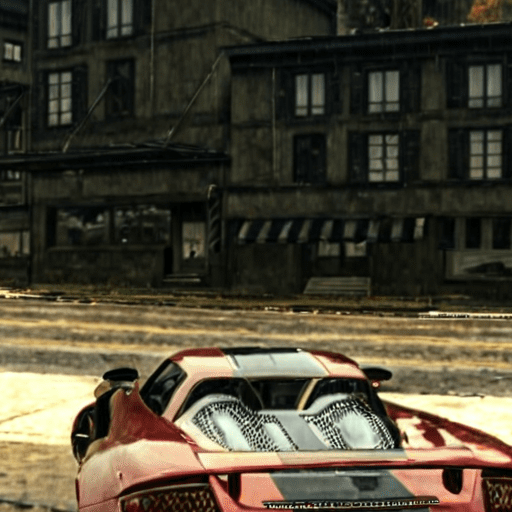

In [15]:
from torchvision import transforms
import numpy as np
import torch

T = transforms.Compose(
    [
        transforms.CenterCrop(512),
    ]
)
# temp_image = torch.tensor(
#     np.array(dataset[0]["edited_image"].convert("RGB")),
#     device="cuda",
#     dtype=torch.float16,
# )
temp_image = dataset[0]["edited_image"].convert("RGB")
# temp_image.shape
T(temp_image)

In [ ]:
x = torch.randn(5, 3, 1080, 1920, device="cuda")
y = torch.nn.functional.interpolate(x, (512, 512))

In [ ]:
import numpy as np

dataset[0]["edited_image"].convert("RGB")
steps = 140
# steps = 500
pure_images = [dataset[i]["edited_image"].convert("RGB") for i in range(steps)]
images = [T(dataset[i]["edited_image"].convert("RGB")) for i in range(steps)]
begin = time.time()
# pipe.set_progress_bar_config(disable=True)
for pos in range(steps):
    # output_image = pipe(**kwarg_inputs).images[0]
    test = T(
        torch.tensor(
            np.array(pure_images[pos]),
            device="cuda",
        )
    )

    temp_image = images[pos]
    pipe(
        prompt=prompt,
        image=T(temp_image),
        num_inference_steps=1,
    ).images[0]
total = time.time() - begin
print(f"Inference time: {total}s {total/steps}s per image")

OutOfMemoryError: CUDA out of memory. Tried to allocate 675.00 GiB. GPU 0 has a total capacity of 23.63 GiB of which 20.78 GiB is free. Process 663712 has 2.74 GiB memory in use. Of the allocated memory 2.09 GiB is allocated by PyTorch, with 141.88 MiB allocated in private pools (e.g., CUDA Graphs), and 168.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)